# Imports

In [1]:
import gc
from operator import concat
import kagglehub
import kagglehub.config
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torchmetrics

import wandb
import pytorch_lightning.loggers as wandb_logger

from RoadDataLoader import RoadDataLoader

from baseline_models.DeepLabV3Model import DeepLabV3Model
from baseline_models.UNET2D import UNET2D
from Swin_UNET.swin_transformer_unet_skip_expand_decoder_sys import SwinTransformerSys


from wrapper_modules.RoadSegmentationModule import RoadSegmentationModule

from loss_and_eval_functions import dice_score, combined_loss, iou_score

/Users/panczelbence/miniconda3/envs/melytanusla_hf/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


# Download

In [2]:
# get kaggle credentials file from ./kaggle.json
with open("./kaggle.json", "r") as f:
    kaggle_json = json.load(f)
kaggel_username = kaggle_json["username"]
kaggel_key = kaggle_json["key"]

In [3]:
kagglehub.config.set_kaggle_credentials(kaggel_username, kaggel_key)

Kaggle credentials set.


In [4]:
# Download latest version
path = kagglehub.dataset_download("payne18/road-detection-dataset-with-masks")
# make data folder if it does not exist
if not os.path.exists("./data"):
    os.mkdir("./data")
# Move data folder to ./data
os.system(f"mv {path} ./data/road-detection-dataset-with-masks")
# remove empty folder
folder_to_remove = path.split("payne18/road-detection-dataset-with-masks")[0] 
os.system((f"rm -r {folder_to_remove}"))

100%|██████████| 3.81G/3.81G [02:31<00:00, 27.0MB/s]

Extracting files...


0

# Load Data

In [2]:
data_path = "./data/road-detection-dataset-with-masks/deepglobe-road-extraction-dataset"
metadata_path = "./data/road-detection-dataset-with-masks/deepglobe-road-extraction-dataset/metadata.csv"

In [3]:
# open metadata
metadata = pd.read_csv(metadata_path)
print(f"All data: {metadata.shape[0]}")

All data: 8570


In [4]:
metadata = metadata[metadata["split"] == "train"]
print(f"Data without validation and test: {metadata.shape[0]}")
metadata["sat_image_path"] = metadata["sat_image_path"].apply(lambda x: os.path.join(data_path, x))
metadata["mask_path"] = metadata["mask_path"].apply(lambda x: os.path.join(data_path, x))
metadata.head()

Data without validation and test: 6226


image_id  split                                     sat_image_path  \
0    100034  train  ./data/road-detection-dataset-with-masks/deepg...   
1    100081  train  ./data/road-detection-dataset-with-masks/deepg...   
2    100129  train  ./data/road-detection-dataset-with-masks/deepg...   
3    100703  train  ./data/road-detection-dataset-with-masks/deepg...   
4    100712  train  ./data/road-detection-dataset-with-masks/deepg...   

                                           mask_path  
0  ./data/road-detection-dataset-with-masks/deepg...  
1  ./data/road-detection-dataset-with-masks/deepg...  
2  ./data/road-detection-dataset-with-masks/deepg...  
3  ./data/road-detection-dataset-with-masks/deepg...  
4  ./data/road-detection-dataset-with-masks/deepg...

# Training

In [10]:
# hyperparameters
batch_size = 8
optimizer = "Adam"
lr = 1e-4
weight_decay = 0.01
epochs = 10
loss_fn = combined_loss
accelerator = "auto"
pretrained = False
image_size = 512
num_workers = 8

In [11]:
dataLoader = RoadDataLoader(metadata, batch_size=batch_size, image_size=image_size, num_workers=num_workers)
# dataLoader.setup()
dataLoader.train_data = pd.read_csv("./metadata/traindata.csv", index_col=0)
dataLoader.val_data = pd.read_csv("./metadata/valdata.csv", index_col=0)
dataLoader.test_data = pd.read_csv("./metadata/testdata.csv", index_col=0)
dataLoader.train_data.head()

image_id  split                                     sat_image_path  \
2988    524867  train  ./data/road-detection-dataset-with-masks/deepg...   
72      110680  train  ./data/road-detection-dataset-with-masks/deepg...   
5370    869652  train  ./data/road-detection-dataset-with-masks/deepg...   
4394     73033  train  ./data/road-detection-dataset-with-masks/deepg...   
2152     40682  train  ./data/road-detection-dataset-with-masks/deepg...   

                                              mask_path  
2988  ./data/road-detection-dataset-with-masks/deepg...  
72    ./data/road-detection-dataset-with-masks/deepg...  
5370  ./data/road-detection-dataset-with-masks/deepg...  
4394  ./data/road-detection-dataset-with-masks/deepg...  
2152  ./data/road-detection-dataset-with-masks/deepg...

In [12]:
train_data_loader = dataLoader.train_dataloader()
val_data_loader = dataLoader.val_dataloader()

In [13]:
# save dataLoader.traindata, dataLoader.valdata and dataLoader.testdata to csv
# dataLoader.train_data.to_csv("./metadata/traindata.csv")
# dataLoader.val_data.to_csv("./metadata/valdata.csv")
# dataLoader.test_data.to_csv("./metadata/testdata.csv")

# Training with Swin_Unet

In [14]:
# hyperparameters


In [15]:
swin_model = SwinTransformerSys(
    img_size=image_size,           # Input méret
    patch_size=4,           # Patch méret
    in_chans=3,             # RGB képek
    num_classes=1,          # Bináris szegmentáció
    embed_dim=16,
    num_heads = (2, 4, 8, 16),
    depths = (2, 2, 6, 2),
    window_size=8,          # Ablak méret
    mlp_ratio=4.0,          # MLP arány
    qkv_bias=True,          # QKV bias
    drop_rate=0.1,          # Dropout ráta
    attn_drop_rate=0.1,     # Attention dropout
    drop_path_rate=0.1,     # Drop path
    norm_layer=nn.LayerNorm,# Rétegnormálás
    ape=False,              # Absolute positional embedding
    patch_norm=True,        # Patch normálás
    use_checkpoint=False    # Checkpoint
)

SwinTransformerSys expand initial----depths:(2, 2, 6, 2);depths_decoder:[1, 2, 2, 2];drop_path_rate:0.1;num_classes:1
---final upsample expand_first---


/Users/panczelbence/miniconda3/envs/melytanusla_hf/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3610.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [16]:
wandb.login()
module = RoadSegmentationModule(swin_model, loss_fn, optimizer)
log = wandb_logger.WandbLogger(project="road-segmentation", log_model="all", name="Swin_UNET")
checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_loss", mode="min")

trainer = pl.Trainer(
    max_epochs=1,
    accelerator="auto",
    logger=log,
    callbacks=[checkpoint_callback]
)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: panczebence (panczebence-budapesti-m-szaki-s-gazdas-gtudom-nyi-egyetem). Use `wandb login --relogin` to force relogin
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(module, train_data_loader, val_data_loader)


  | Name         | Type               | Params | Mode 
------------------------------------------------------------
0 | model        | SwinTransformerSys | 1.2 M  | train
1 | precision_fn | BinaryPrecision    | 0      | train
------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.791     Total estimated model params size (MB)
381       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


# Training with DeepLabV3Model

In [18]:
!chmod 777 -r
wandb.login()
model = DeepLabV3Model(pretrained=pretrained)
module = RoadSegmentationModule(model, loss_fn, optimizer)
log = wandb_logger.WandbLogger(project="road-segmentation", log_model="all", name="DeepLabV3Model")
checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_loss", mode="min")

trainer = pl.Trainer(
    max_epochs=epochs,
    accelerator="auto",
    logger=log,
    callbacks=[checkpoint_callback]
)

chmod: cannot access '777': No such file or directory


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: panczebence (panczebence-budapesti-m-szaki-s-gazdas-gtudom-nyi-egyetem). Use `wandb login --relogin` to force relogin
/home/ad.adasworks.com/bence.panczel/miniconda3/envs/melytanulas_hf/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ad.adasworks.com/bence.panczel/miniconda3/envs/melytanulas_hf/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [19]:
trainer.fit(module, train_data_loader, val_data_loader)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type            | Params | Mode 
---------------------------------------------------------
0 | model        | DeepLabV3Model  | 39.6 M | train
1 | precision_fn | BinaryPrecision | 0      | train
---------------------------------------------------------
39.6 M    Trainable params
0         Non-trainable params
39.6 M    Total params
158.535   Total estimated model params size (MB)
185       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [20]:
wandb.finish()
depplabv3_model_path = checkpoint_callback.best_model_path
print(depplabv3_model_path)

./road-segmentation/tr0a7fqm/checkpoints/epoch=8-step=5049.ckpt


In [21]:
# save the best model as DeepLabV3_best_model.cpkt
!cp {depplabv3_model_path} ./models//DeepLabV3_best_model.cpkt

cp: cannot create regular file './models//DeepLabV3_best_model.cpkt': No such file or directory


# Training with UNET2D

In [22]:
dataLoader.batch_size = 8
train_data_loader = dataLoader.train_dataloader()
val_data_loader = dataLoader.val_dataloader()

In [23]:
wandb.login()
model = UNET2D(3, 1, chanel_list=[8, 16, 32, 64])
module = RoadSegmentationModule(model, loss_fn, optimizer)
log = wandb_logger.WandbLogger(project="road-segmentation", log_model="all", name="UNET2D")
checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_loss", mode="min")

trainer = pl.Trainer(
    max_epochs=10,
    accelerator="auto",
    logger=log,
    callbacks=[checkpoint_callback]
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [24]:
trainer.fit(module, train_data_loader, val_data_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type            | Params | Mode 
---------------------------------------------------------
0 | model        | UNET2D          | 487 K  | train
1 | precision_fn | BinaryPrecision | 0      | train
---------------------------------------------------------
487 K     Trainable params
0         Non-trainable params
487 K     Total params
1.949     Total estimated model params size (MB)
72        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [25]:
wandb.finish()
unet2d_model_path = checkpoint_callback.best_model_path
print(unet2d_model_path)

./road-segmentation/12mkk08h/checkpoints/epoch=8-step=5049.ckpt


In [26]:
# save the best model as UNET2D_best_model.cpkt
!cp {unet2d_model_path} ./models/UNET2D_best_model.cpkt

cp: cannot create regular file './models/UNET2D_best_model.cpkt': No such file or directory


# Testing models

In [27]:
def show_result(x, y, pred, title, sigmoid=True):
    if sigmoid:
        pred = torch.sigmoid(pred)
    fig, ax = plt.subplots(4, 3, figsize=(15, 25))
    fig.suptitle(title)
    for i in range(4):
        # denormalize x
        image = x[i] * 0.5 + 0.5
        ax[i, 0].imshow(image.permute(1, 2, 0))
        ax[i, 0].set_title("Input")
        ax[i, 0].axis("off")
        ax[i, 1].imshow(y[i].squeeze(0))
        ax[i, 1].set_title("Target")
        ax[i, 1].axis("off")
        ax[i, 2].imshow(pred[i].squeeze(0).detach().numpy())
        ax[i, 2].set_title("Prediction")
        ax[i, 2].axis("off")
    #tight layout
    plt.tight_layout()
    plt.show()

In [28]:
import time

def eval_model(model, dataLoader, device, model_name='model'):
    model.to(device)
    model.eval()
    
    precision = torchmetrics.Precision(task="binary").to(device)
    accuracy = torchmetrics.Accuracy(task='binary').to(device)
    
    total_IoU, total_dice, total_precision, total_accuracy, total_ABD = 0, 0, 0, 0, 0
    num_batches = len(dataLoader)
    
    inference_time = []
    with torch.no_grad():
        for x, y in dataLoader:
            x = x.to(device)
            y = y.to(device)
            
            start = time.time()
            pred = model(x)
            torch.cuda.synchronize()
            end = time.time()
            
            inference_time.append(end - start)
            
            total_IoU += iou_score(pred, y)
            total_dice += dice_score(pred, y)
            
            total_precision += precision(pred, y)
            total_accuracy += accuracy(pred, y)
 
    avg_IoU = total_IoU / num_batches
    avg_dice = total_dice / num_batches
    avg_precision = total_precision / num_batches
    avg_accuracy = total_accuracy / num_batches
    avg_inference_time = sum(inference_time) / len(inference_time)
    
    print(f"{model_name} IoU: {avg_IoU}")
    print(f"{model_name} Dice: {avg_dice}")
    print(f"{model_name} Precision: {avg_precision}")
    print(f"{model_name} Accuracy: {avg_accuracy}")
    print(f"{model_name} Inference time: {avg_inference_time}")
    return avg_IoU, avg_dice, avg_precision, avg_accuracy, avg_inference_time

In [29]:
dataLoader = RoadDataLoader(metadata, batch_size=4, image_size=512, num_workers=8)
dataLoader.train_data = pd.read_csv("./metadata/traindata.csv", index_col=0)
dataLoader.val_data = pd.read_csv("./metadata/valdata.csv", index_col=0)
dataLoader.test_data = pd.read_csv("./metadata/testdata.csv", index_col=0)

In [30]:
test_dataLoader = dataLoader.test_dataloader()

for batch in test_dataLoader:
    x, y = batch
    break


In [31]:
deeplabv3_model_path = "./models/DeepLabV3_best_model.cpkt"
unet2d_model_path = "./models/UNET2D_best_model.cpkt"

if not os.path.exists("./models"):
    os.mkdir("./models")
#check if file exists
if not os.path.exists(deeplabv3_model_path):
    !curl -L -o ./models/DeepLabV3_best_model.cpkt https://huggingface.co/beboi0122/Vision_transformers_for_image_segmentation_HF/resolve/main/DeepLabV3_best_model.cpkt
if not os.path.exists(unet2d_model_path):
    !curl -L -o ./models/UNET2D_best_model.cpkt https://huggingface.co/beboi0122/Vision_transformers_for_image_segmentation_HF/resolve/main/UNET2D_best_model.cpkt


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1132  100  1132    0     0   3675      0 --:--:-- --:--:-- --:--:--  3687
100  454M  100  454M    0     0  35.5M      0  0:00:12  0:00:12 --:--:-- 33.8M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1130  100  1130    0     0   5490      0 --:--:-- --:--:-- --:--:--  5512
100 5829k  100 5829k    0     0  9326k      0 --:--:-- --:--:-- --:--:-- 16.6M


### DeepLabV3Model evaluation

In [32]:
deeplabv3_state_dict = torch.load(deeplabv3_model_path)["state_dict"]
deeplabv3_state_dict = {k.replace("model.model.", "model."): v for k, v in deeplabv3_state_dict.items()}
deeplabv3_model = DeepLabV3Model(pretrained=False)
deeplabv3_model.load_state_dict(deeplabv3_state_dict, strict=False)
deeplabv3_module = RoadSegmentationModule(deeplabv3_model, combined_loss, optimizer)

/tmp/ipykernel_2102578/3193918698.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  deeplabv3_state_dict = torch.load(deeplabv3_model_path)["state_dict"]
/home/ad.adaswork

In [33]:
device = "cuda" if torch.cuda.is_available() else "cpu"
deeplabv3_module.to(device)
x = x.to(device)
y = y.to(device)

deeplabv3_module.eval()
pred = deeplabv3_module(x)

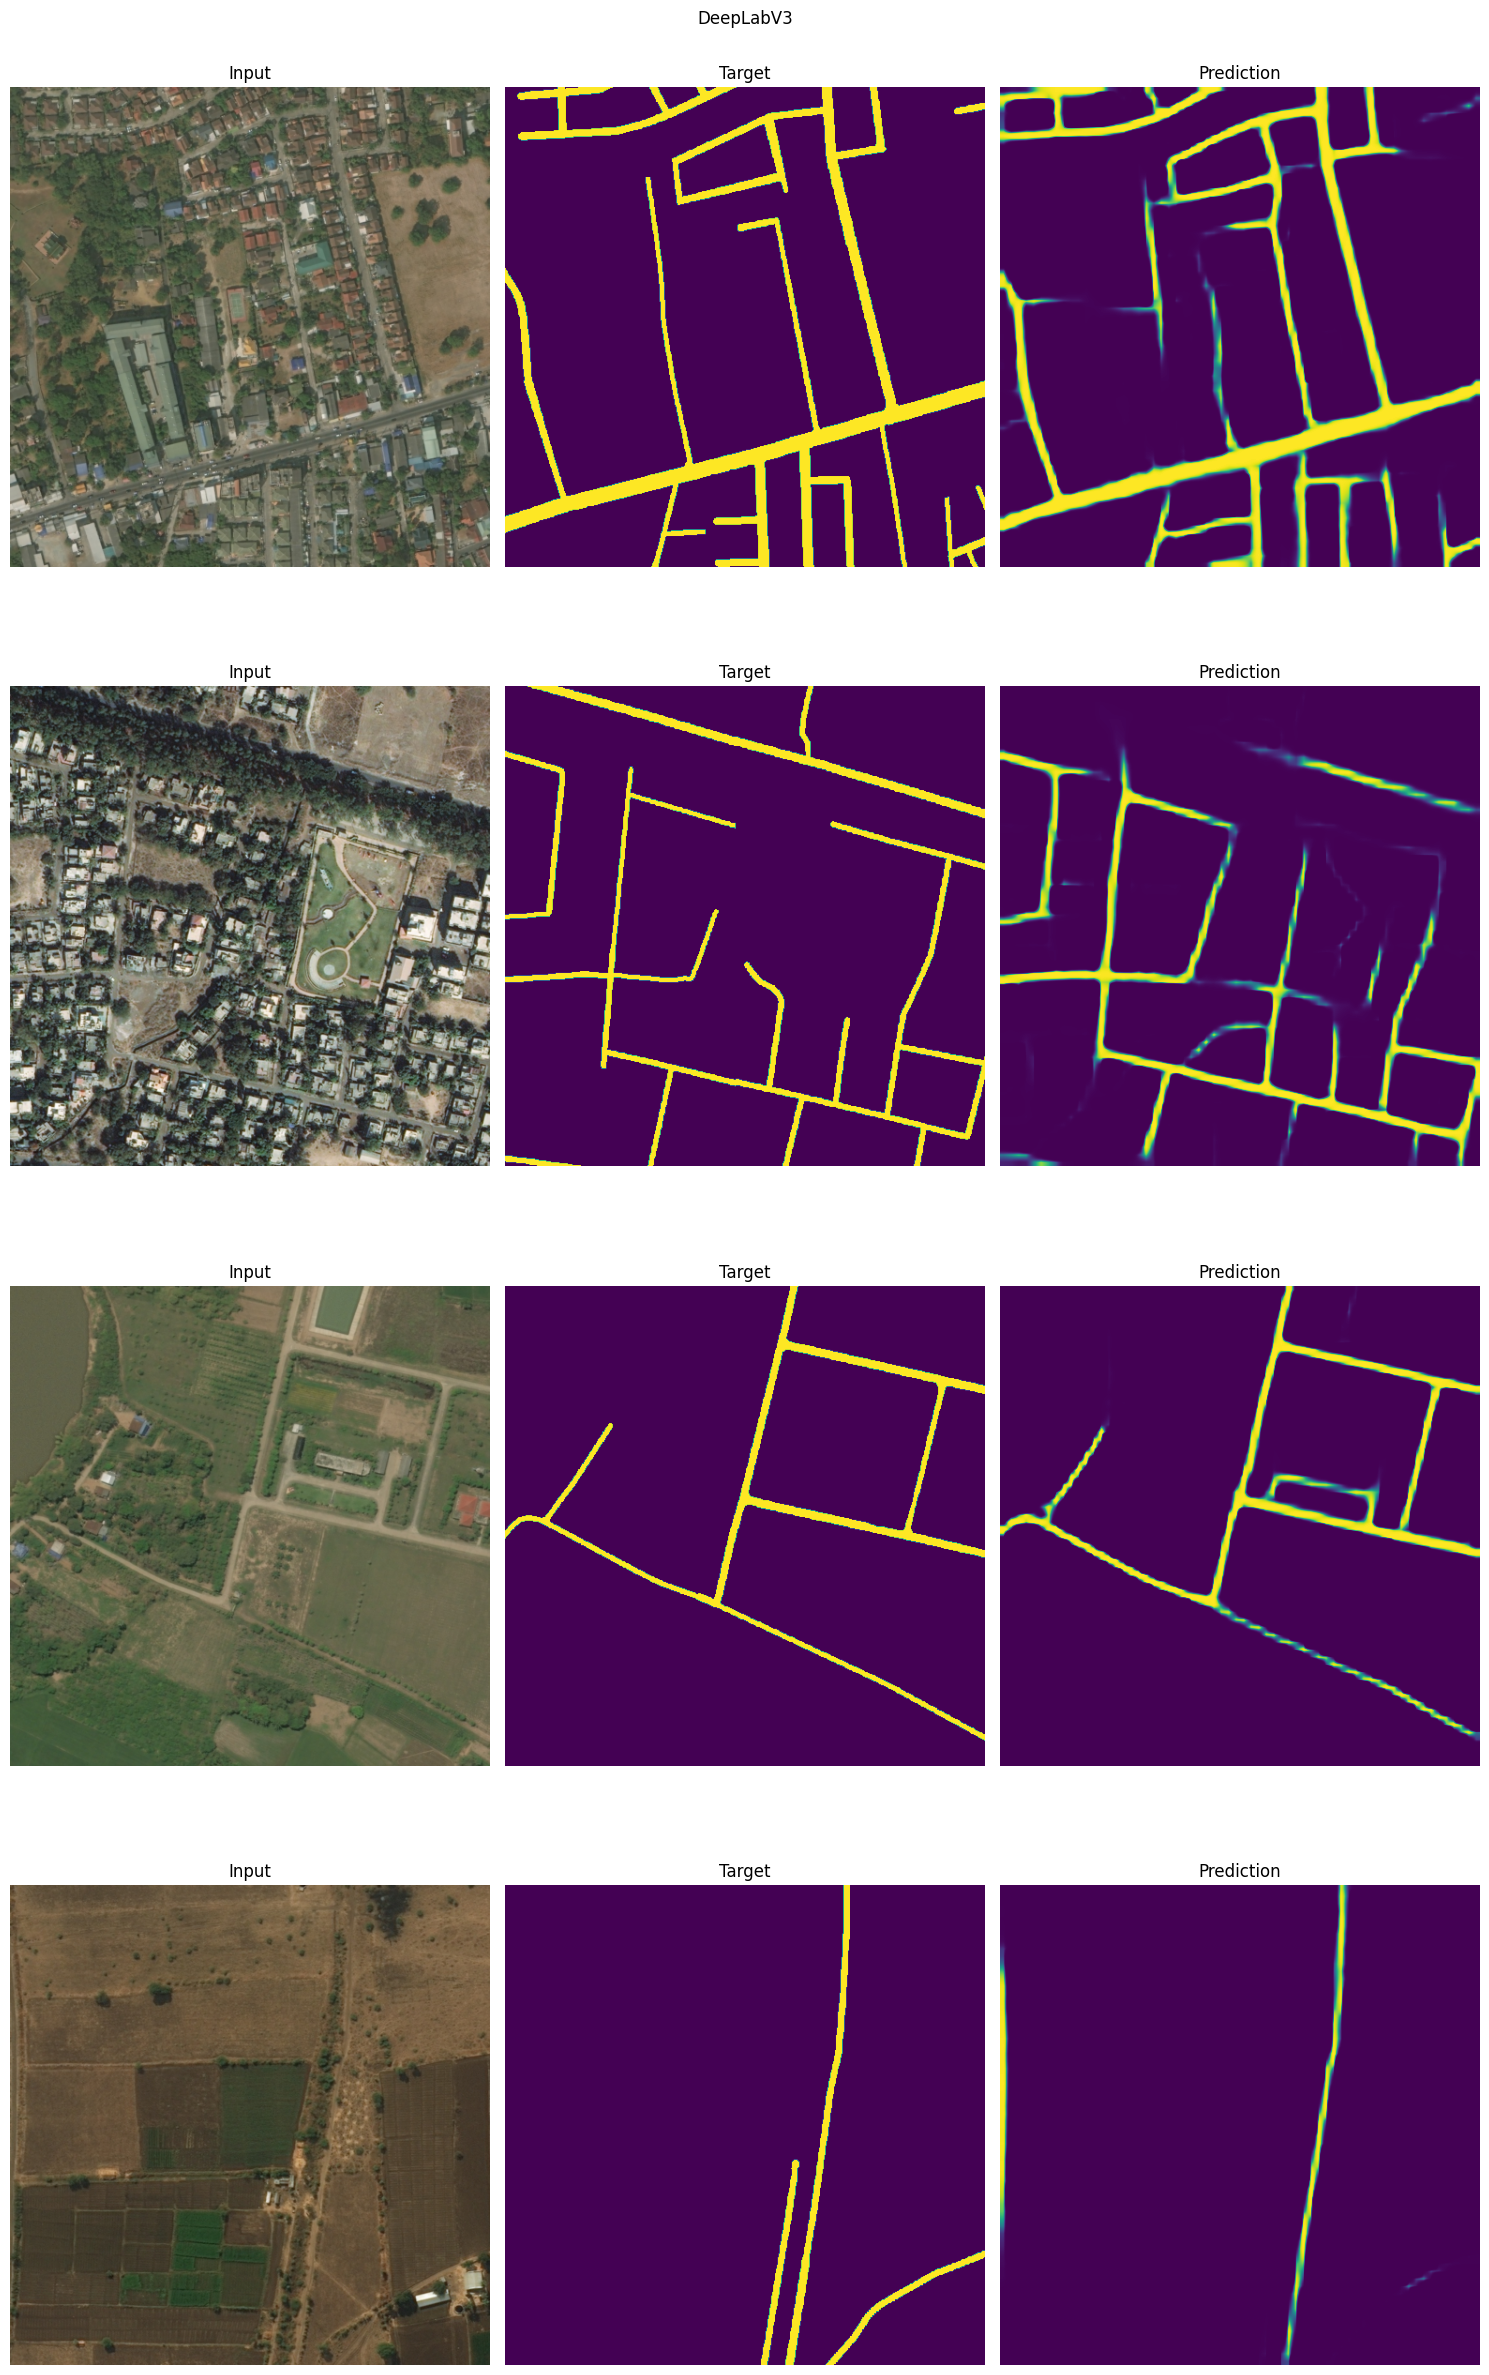

In [34]:
show_result(x.cpu(), y.cpu(), pred.cpu(), "DeepLabV3", sigmoid=True)

In [35]:
test_dataLoader = dataLoader.test_dataloader()
DLV3_avg_IoU, DLV3_avg_dice, DLV3_avg_precision, DLV3_avg_accuracy, DLV3_avg_inference_time = eval_model(deeplabv3_module, test_dataLoader, device, "DeepLabV3")

DeepLabV3 IoU: 0.5030822157859802
DeepLabV3 Dice: 0.6664144992828369
DeepLabV3 Precision: 0.7194785475730896
DeepLabV3 Accuracy: 0.9748151302337646
DeepLabV3 Inference time: 0.24511498832702636


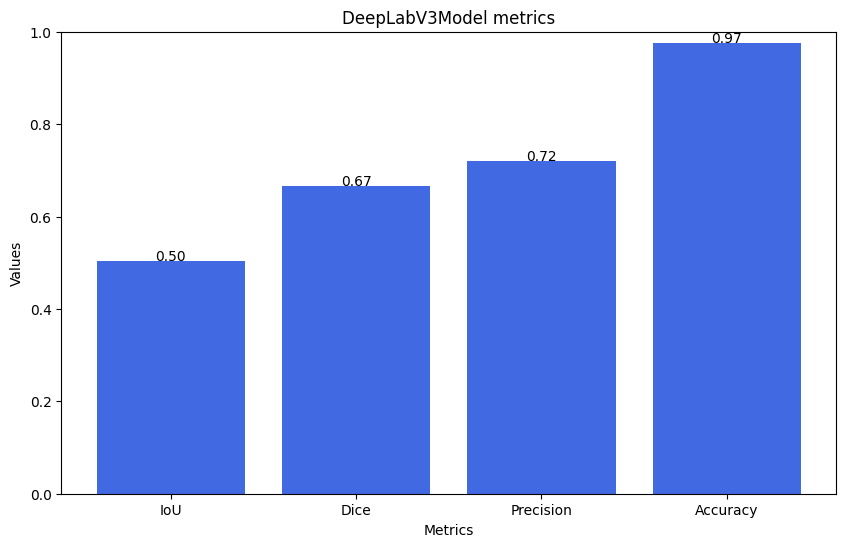

In [36]:
# show result
metrics = ['IoU', 'Dice', 'Precision', 'Accuracy']
values = [DLV3_avg_IoU.cpu(), DLV3_avg_dice.cpu(), DLV3_avg_precision.cpu(), DLV3_avg_accuracy.cpu()]

plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color='royalblue')

plt.title('DeepLabV3Model metrics')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.ylim(0, 1)

for i, v in enumerate(values):
    plt.text(i, v + 0.01, f'{v:.2f}', ha='center', va='center')


plt.show()

### UNET2D evaluation

In [37]:
unet2d_state_dict = torch.load(unet2d_model_path)["state_dict"]
unet2d_state_dict = {k.replace("model.", ""): v for k, v in unet2d_state_dict.items()}
unet2d_model = UNET2D(3, 1, chanel_list=[8, 16, 32, 64])
unet2d_model.load_state_dict(unet2d_state_dict, strict=False)
unet2d_module = RoadSegmentationModule(unet2d_model, loss_fn, optimizer)


/tmp/ipykernel_2102578/887313176.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  unet2d_state_dict = torch.load(unet2d_model_path)["state_dict"]


In [38]:
device = "cuda" if torch.cuda.is_available() else "cpu"
unet2d_module.to(device)
x = x.to(device)
y = y.to(device)

unet2d_module.eval()
pred = unet2d_module(x)

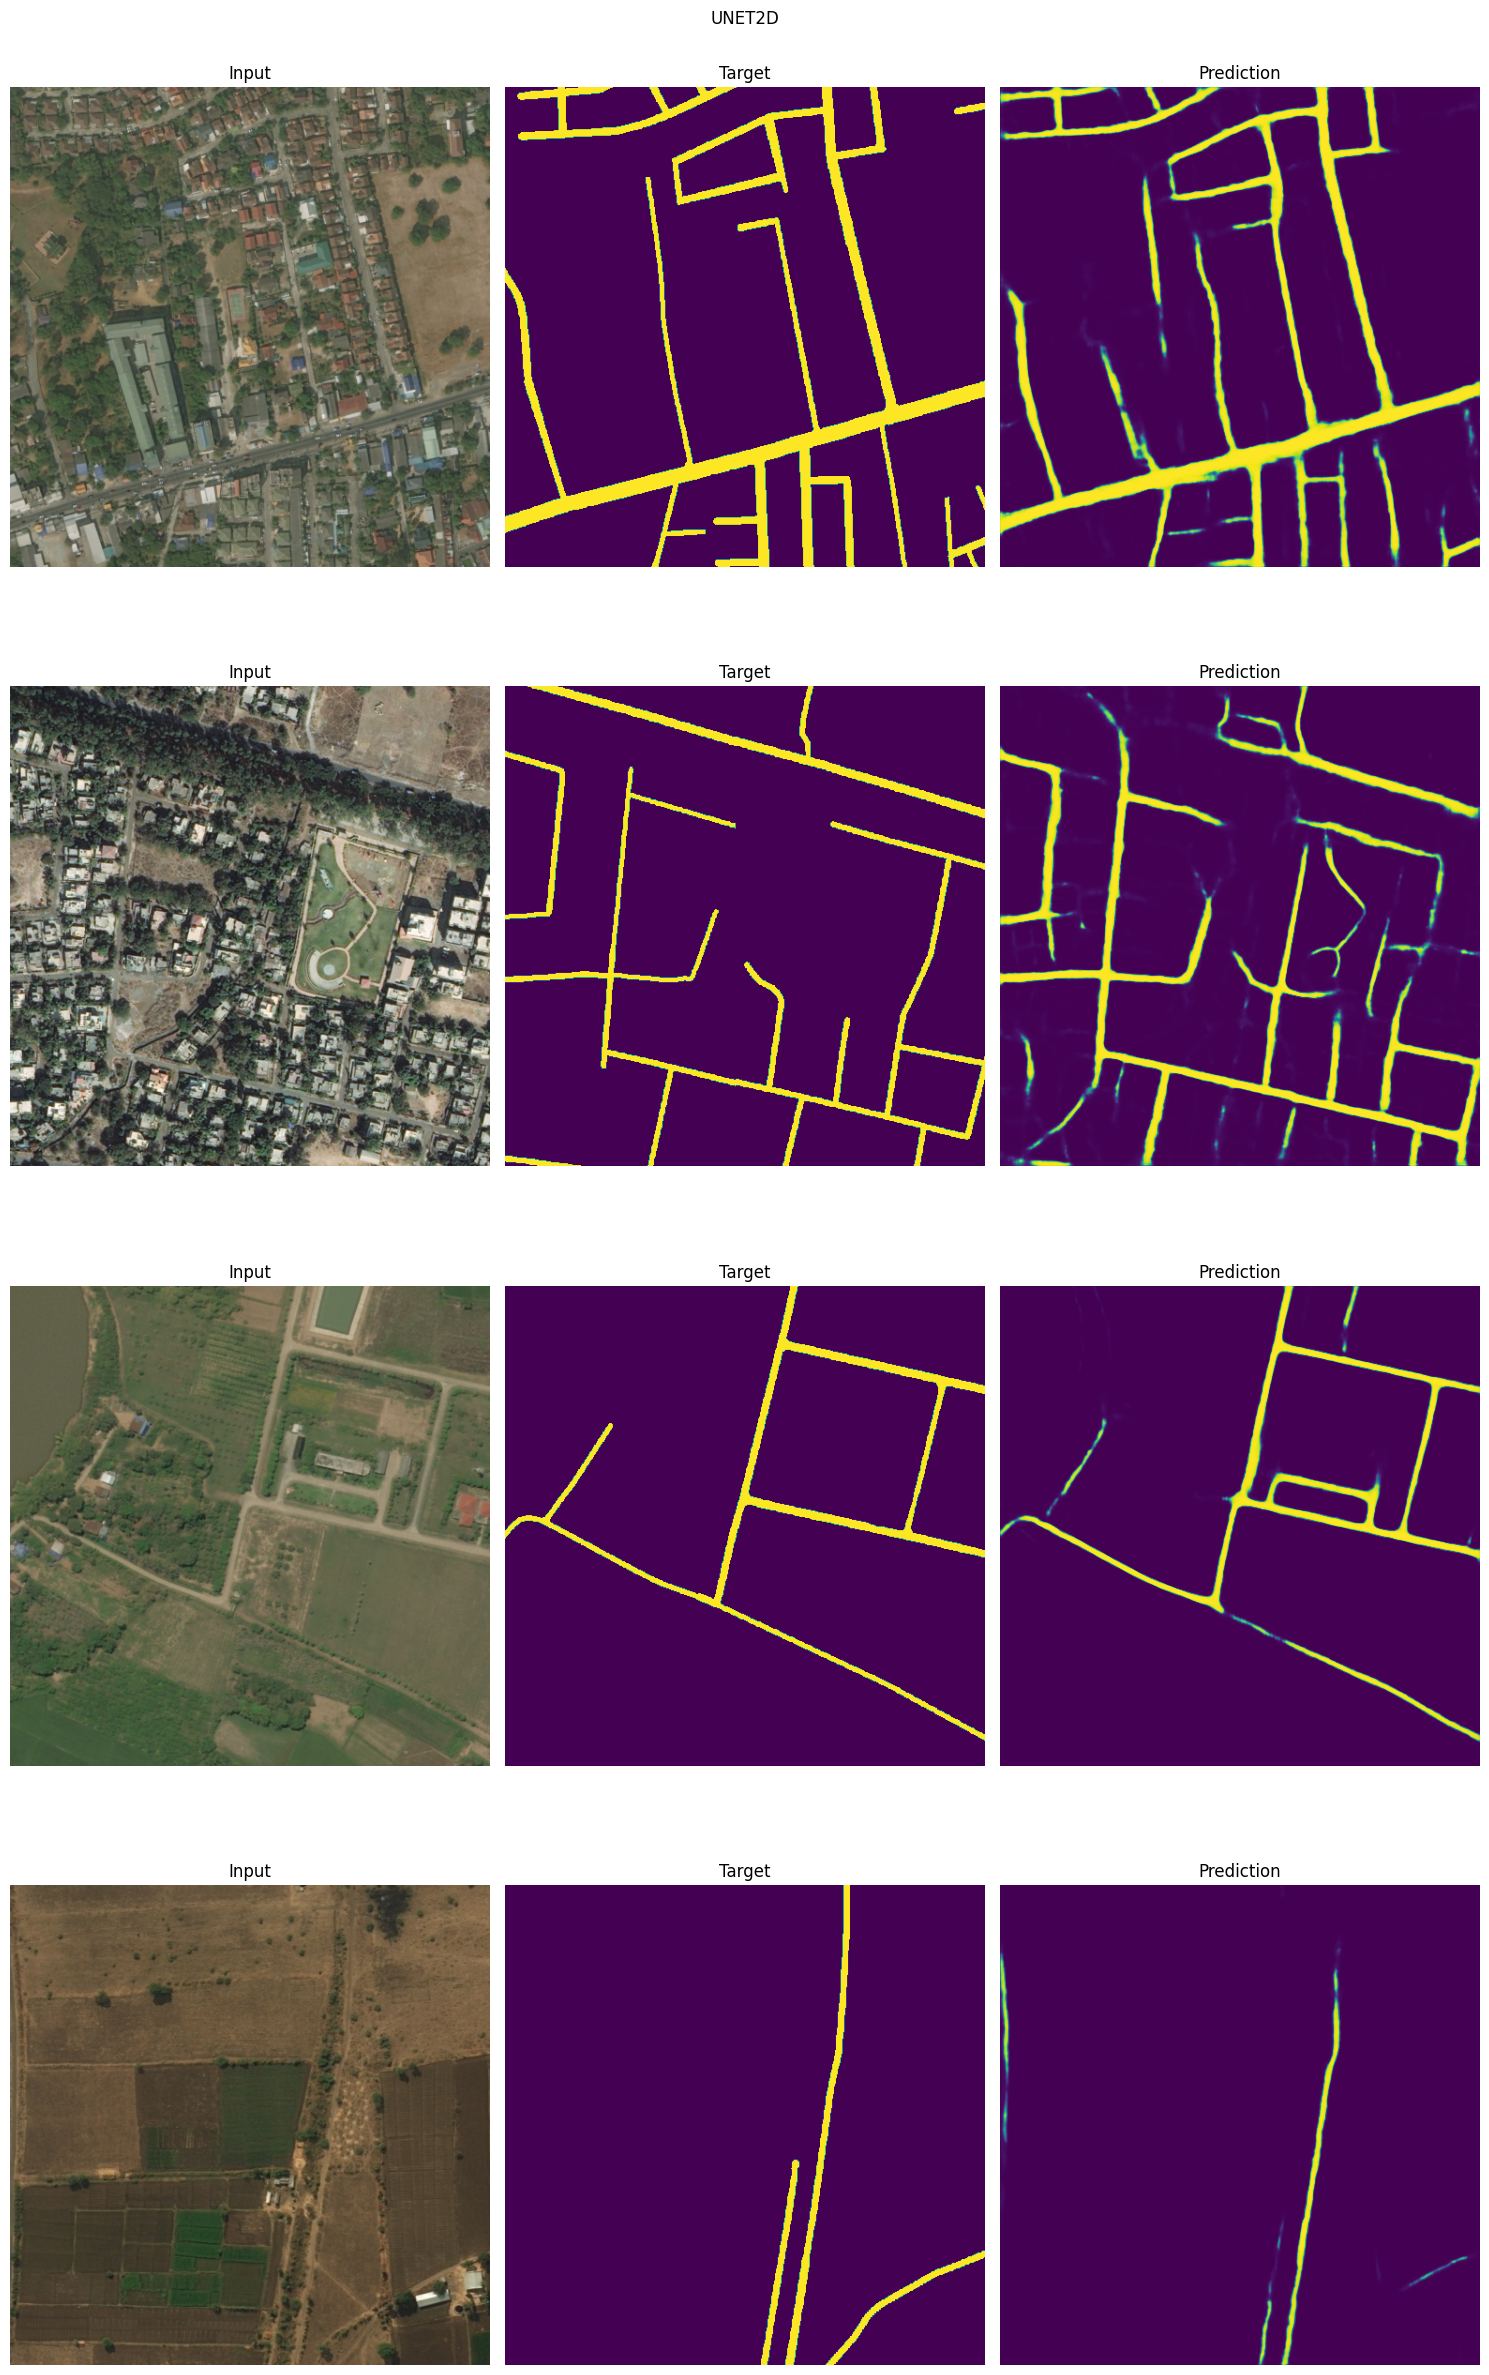

In [39]:
show_result(x.cpu(), y.cpu(), pred.cpu(), "UNET2D", sigmoid=True)

In [40]:
test_dataLoader = dataLoader.test_dataloader()
UNET2D_avg_IoU, UNET2D_avg_dice, UNET2D_avg_precision, UNET2D_avg_accuracy, UNET2D_avg_inference_time = eval_model(unet2d_module, test_dataLoader, device, "UNET2D")

UNET2D IoU: 0.47581008076667786
UNET2D Dice: 0.6419040560722351
UNET2D Precision: 0.6846802830696106
UNET2D Accuracy: 0.9725205302238464
UNET2D Inference time: 0.01555750846862793


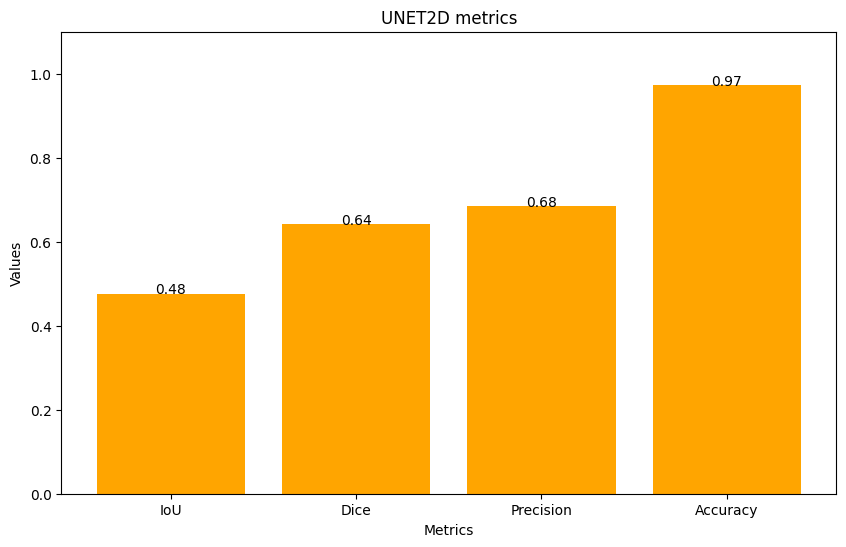

In [41]:
# show results
metrics = ['IoU', 'Dice', 'Precision', 'Accuracy']
values = [UNET2D_avg_IoU.cpu(), UNET2D_avg_dice.cpu(), UNET2D_avg_precision.cpu(), UNET2D_avg_accuracy.cpu()]

plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color='orange')

plt.title('UNET2D metrics')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.ylim(0, 1.1)

for i, v in enumerate(values):
    plt.text(i, v + 0.01, f'{v:.2f}', ha='center', va='center')
    
plt.show()

### Comparison

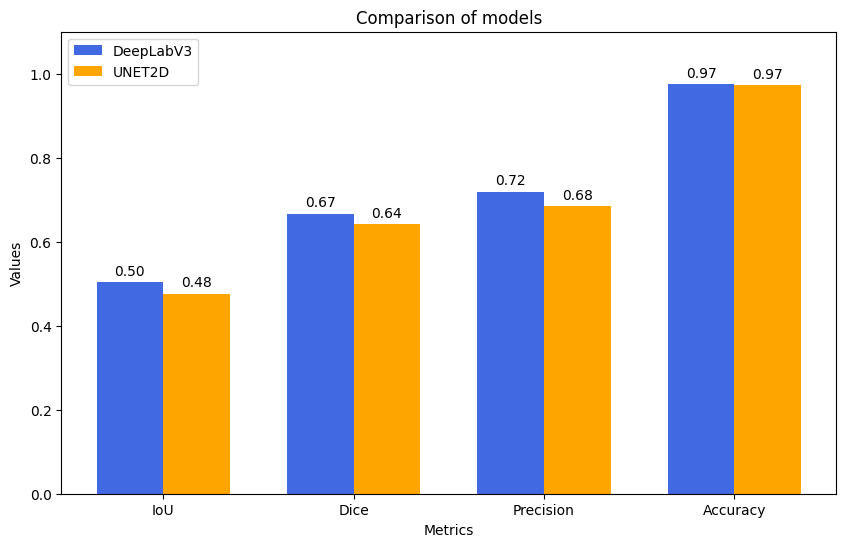

In [42]:
metrics = ['IoU', 'Dice', 'Precision', 'Accuracy']
u2_values = [UNET2D_avg_IoU.cpu(), UNET2D_avg_dice.cpu(), UNET2D_avg_precision.cpu(), UNET2D_avg_accuracy.cpu()]
d3_values = [DLV3_avg_IoU.cpu(), DLV3_avg_dice.cpu(), DLV3_avg_precision.cpu(), DLV3_avg_accuracy.cpu()]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(x - width/2, d3_values, width, label='DeepLabV3', color='royalblue')
bar2 = ax.bar(x + width/2, u2_values, width, label='UNET2D', color='orange')

ax.set_xlabel('Metrics')
ax.set_ylabel('Values')
ax.set_title('Comparison of models')
ax.set_ylim(0, 1.1)
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

def add_label(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 ponttal feljebb
                    textcoords="offset points",
                    ha='center', va='bottom')
        
add_label(bar1)
add_label(bar2)


plt.show()

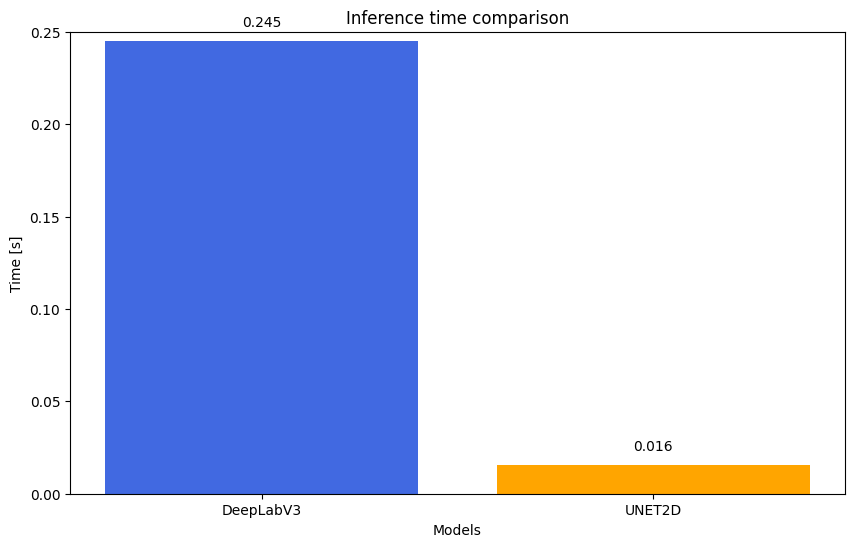

In [43]:
# compare inference time
inference_times = [DLV3_avg_inference_time, UNET2D_avg_inference_time]
models = ['DeepLabV3', 'UNET2D']

plt.figure(figsize=(10, 6))
plt.bar(models, inference_times, color=['royalblue', 'orange'])

plt.title('Inference time comparison')
plt.ylabel('Time [s]')
plt.xlabel('Models')
plt.ylim(0, 0.25)

for i, v in enumerate(inference_times):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='center')


plt.show()